In [12]:
import pandas as pd
import shap
import joblib
from catboost import Pool
import numpy as np
import matplotlib.pyplot as plt

In [13]:
# Open the pickle file in read-binary mode
with open("../models/needed_variables.pkl", "rb") as f:
    df = joblib.load(f)

In [14]:
X = df["X_test"]
y = df["y_test"]

In [15]:
with open("../models/step2_catboost_timesplit.pkl", "rb") as f:
    model = joblib.load(f)

## SHAP Feature Importance

In [16]:
# Create CatBoost Pool
pool = Pool(data=X, label=y)

# Get SHAP values (last column = base value)
shap_values = model.get_feature_importance(type="ShapValues", data=pool)

SHAP calculates how much each feature contributes to moving the prediction away from the average prediction and SHAP Feature Importance is computed by looking at the average absolute SHAP value for each feature across all samples.

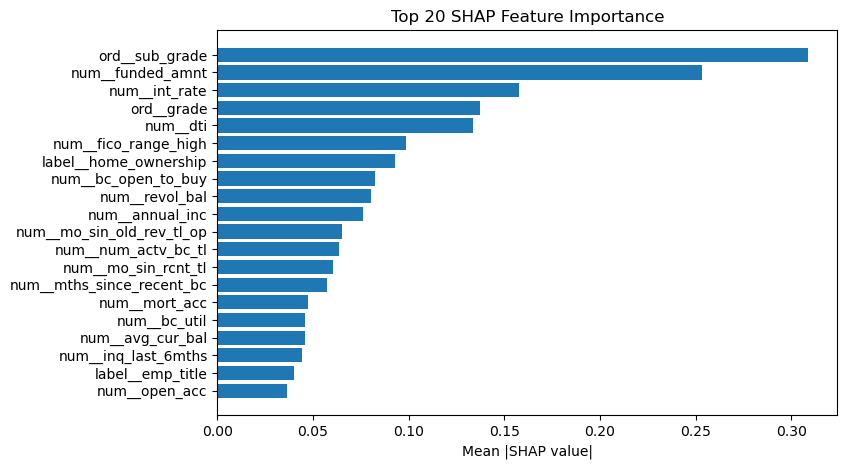

In [17]:
# Compute mean |SHAP| importance
feature_importance = np.abs(shap_values[:, :-1]).mean(axis=0)
feature_names = X.columns
sorted_idx = np.argsort(feature_importance)[::-1]

# Keep only top 20
top_n = 20
top_idx = sorted_idx[:top_n]

plt.figure(figsize=(8, 5))
plt.barh([feature_names[i] for i in top_idx], feature_importance[top_idx])
plt.xlabel("Mean |SHAP value|")
plt.title(f"Top {top_n} SHAP Feature Importance")
plt.gca().invert_yaxis()
plt.show()

The SHAP Feature Importance plot shows that ord__sub_grade is the most important feature, closeley followed by num__funded_amnt. The top five of most important features is completed by num__int_rate, ord__grade and num__dti.

## SHAP Force Plot

SHAP Force Plot shows how features push the prediction away from the baseline.

In [18]:
shap.initjs()

# Pick one observation
index_to_explain = 0
single_X = X.iloc[[index_to_explain]]

# Extract SHAP values and base value for this observation
single_shap_values = shap_values[index_to_explain, :-1]
base_value = shap_values[index_to_explain, -1]

# Interactive force plot
shap.force_plot(base_value, single_shap_values, single_X)

We can see here that negative contributions win and the prediction is pushed down to -0.19.

In [19]:
# Create force plot
force_plot = shap.force_plot(base_value, single_shap_values, single_X)

# Save to HTML
shap.save_html("force_plot.html", force_plot)
print("Force plot saved as force_plot.html")

Force plot saved as force_plot.html


## SHAP Waterfall Plot

SHAP Waterfall Plot visualizes how  the machine learning model, CatBoost in this case, made a specific prediction for a single data point. It shows, step by step, how the model’s baseline prediction is adjusted by each feature’s SHAP value until the final prediction is reached. On x-axis it displays contrcontribution to prediction $f(x)$. On x-axis there is the center line, $E[f(X)]$, which is the average model prediction across all samples (basically the model’s baseline output). Features in red are the positive contributions, meaning that they increase the prediction relative to the baseline and features in blue are the negative contributions, meaning that they decrease the prediction relative to the baseline.

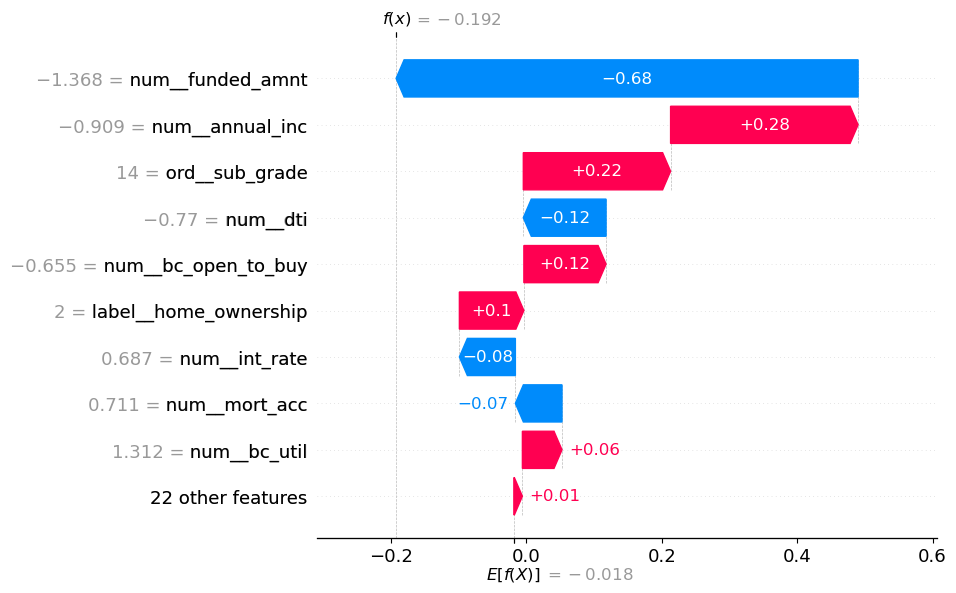

In [20]:
# Waterfall plot
shap.plots.waterfall(
    shap.Explanation(
        values=single_shap_values,
        base_values=base_value,
        data=single_X.values[0],
        feature_names=single_X.columns.tolist(),
    )
)

From the plot we van see that the center line is at -0.018 and the final prediction for selected data point at -0.192. The largest contribution comes from num__funded_amnt, which pulls the prediction downward with with the SHAP effect of -0.68. It is not counterbalanced by the 2 biggest positive contributions coming from num__anual_inc and ord__sub_grade that have the SHAP effect values of accordingly +0.28 and +0.22.

## SHAP Summary Plot

SHAP summary plot explains how different features contributed to the model’s predictions. In SHAP summary plot each
point represents a feature’s effect on one prediction. The x-axis shows the SHAP value (how much the feature pushes the prediction up or down).The color shows whether the feature value is high (red) or low (blue).

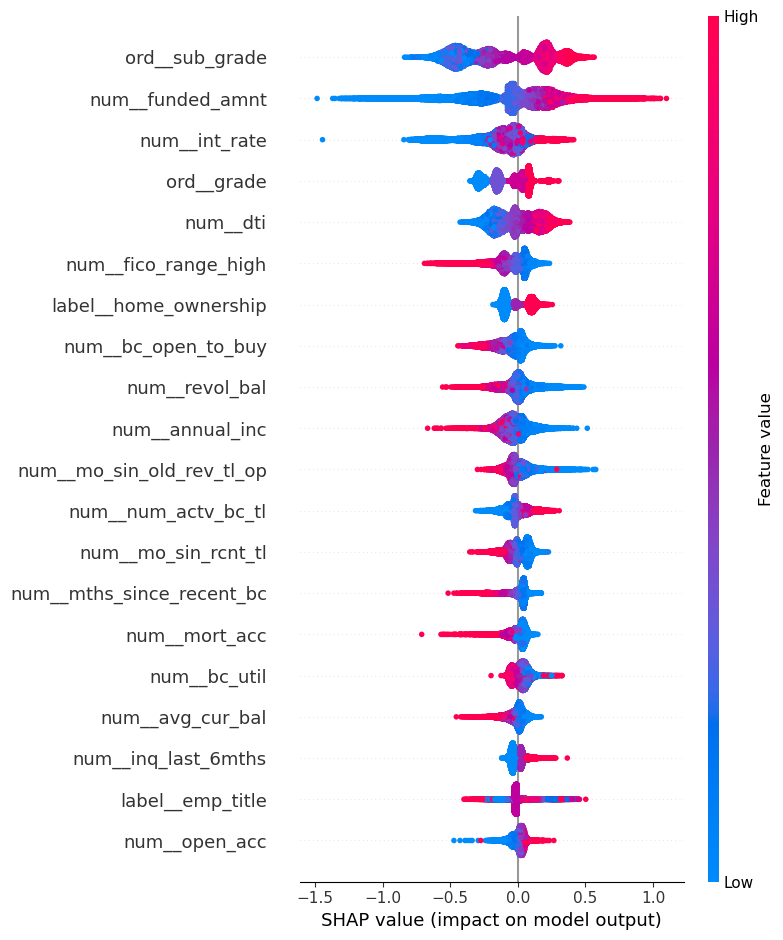

In [21]:
# SHAP summary plot
shap.summary_plot(shap_values[:, :-1], X)

This SHAP summary plot shows the most important factors driving the model’s predictions. Features such as ord__sub_grade, num__funded_amnt, num__int_rate, and ord__grade have the strongest influence. When those features have high values, they generally push predictions upward (lower risk), while for example, higher values of num__fico_range_high or num_annual_inc push predictions downward (higher risk).